# Clarke's experiment numerical circuit simulation for a single-photon pure polarization state

## Context

In this notebook we simulate Clarke's experiment (https://doi.org/10.1103/PhysRevA.63.040305) for unambiguous discrimination of single-photon polarization states with the addition of an ancilla photon in one of the input ports. For this purpose we use the *strawberry fields* package. We simulate the experiment for a single photon input.

## Output

- Numerical output photon distributions for a single photon

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

import matplotlib.pyplot as plt

# set the random seed
np.random.seed(42)

In [3]:
n_paths = 3
n_modes = n_paths*2
cutoff_dim = 2

#======== Initial State Preparation ==========

# Vacuum State Array
VacuumState = np.zeros([cutoff_dim] * n_modes, dtype='complex')

# Prepare initial qubit state in Fock basis
theta = pi
phi = 0

InitialState = np.copy(VacuumState)
InitialState[1,0,0,0,0,0] = np.cos(theta/2)
InitialState[0,1,0,0,0,0] = np.sin(theta/2)*np.exp(1j*phi)

#============ Gates' Construction =============

SWAP = Interferometer(np.array([[0,1],[1,0]]))

def HWP(angle):
    x = np.cos(2*angle)
    y = np.sin(2*angle)
    return Interferometer(np.array([[x,y],[y,-x]]))

#============ Other parameters ===============

alpha = pi/8 # half-angle between states to discriminate
opt_wp4_angle = np.arcsin(np.tan(alpha))/2 # optimal WP4 angle for discrimination

In [4]:
prog = sf.Program(n_modes)
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})

with prog.context as q:
    # prepare initial states
    Ket(InitialState) | q

    # apply gates
    HWP(alpha/2) | (q[0], q[1]) # WP0, for preparation of H and D into "standard" form
    SWAP | (q[1], q[3]) # PBS2
    HWP(opt_wp4_angle) | (q[0], q[1]) # WP4
    SWAP | (q[1], q[5]) # PBS3
    HWP(pi/4) | (q[2] , q[3]) # WP5
    SWAP | (q[3], q[5]) # PBS5
    HWP(3*pi/8) | (q[2], q[3]) # WP6

    # count photons
    MeasureFock() | q

In [5]:
n_shots = 1000
psi0_counts = 0 # inconclusive result
psi1_counts = 0 # psi minus state
psi2_counts = 0 # psi plus state

for n in range(n_shots):
    result = eng.run(prog, shots=1)
    psi0_counts += result.samples[0,0]
    psi1_counts += result.samples[0,2]
    psi2_counts += result.samples[0,3]

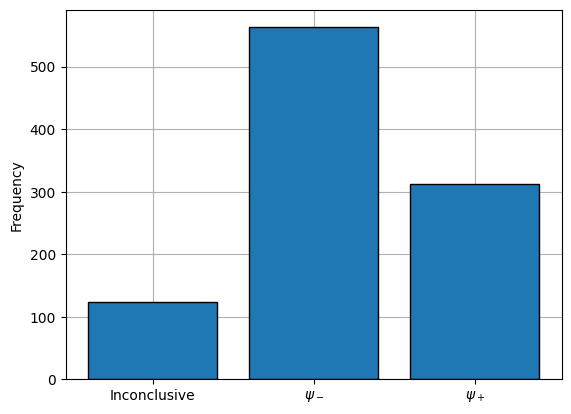

In [6]:
data = np.array([psi0_counts, psi1_counts, psi2_counts])
plt.bar(range(3), data, ec='k',zorder=2)
plt.grid(zorder=1)
plt.xticks(range(3), ["Inconclusive",r"$\psi_-$",r"$\psi_+$"])
plt.ylabel("Frequency")
plt.show()